In [43]:
import importlib
import json
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib
from fusion_bench.utils.json import load_from_json

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

PROJECT_ROOT = Path(
    os.path.abspath(
        os.path.join(importlib.import_module("fusion_bench").__path__[0], "..")
    )
)

In [44]:
def gather_single_model_report(base_model: str):
    result_dir = PROJECT_ROOT / 'outputs'/'single_task_evaluation'/ base_model
    reports = defaultdict(list)
    model_names = os.listdir(result_dir)
    for model_name in model_names:
        report_path = result_dir / model_name / 'report.json'
        data = load_from_json(report_path)
        for task_name, task_report in data.items():
            if task_name != 'model_info' and task_name != 'average':
                reports['model_name'].append(model_name)
                reports['task_name'].append(task_name)
                reports['accuracy'].append(task_report['accuracy'])
                reports['loss'].append(task_report['loss'])
    return pd.DataFrame(reports)

In [45]:
def get_pretrained_expert_accuracy(df: pd.DataFrame):
    tasks = df['task_name'].unique()
    pretrained_accuracy = {}
    expert_accuracy = {}
    pretrained_data = df[df['model_name'] == 'pretrained']
    for task in tasks:
        pretrained_acc = pretrained_data[pretrained_data['task_name'] == task]['accuracy']
        assert len(pretrained_acc) == 1
        pretrained_accuracy[task] = float(pretrained_acc.values[0])

        expert_data = df[df['model_name'] == task]
        expert_acc = expert_data[expert_data['task_name'] == task]['accuracy']
        assert len(expert_acc) == 1
        expert_accuracy[task] = float(expert_acc.values[0])

    return pretrained_accuracy, expert_accuracy

In [48]:
def plot_radar_chart(df, ax):
    # Get the task names (excluding the model_name column)
    categories = [col for col in df.columns if col != 'model_name']
    
    # Number of variables
    num_vars = len(categories)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the circle
    
    # Plot data
    for idx, row in df.iterrows():
        values = row[categories].values.flatten().tolist()
        values += values[:1]  # Complete the circle
        
        # Plot data
        ax.plot(angles, values, 'o-', linewidth=2, label=row['model_name'])
        ax.fill(angles, values, alpha=0.25)
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

In [50]:
for base_model in ['vit-b-32', 'vit-b-16', 'vit-l-14']:
    df = gather_single_model_report(base_model)
    df.to_csv(f'results/{base_model}.csv', index=False)

    pretrained_accuracy, expert_accuracy = get_pretrained_expert_accuracy(df)
    data = defaultdict(list)
    data['model_name'].append('pretrained')
    for task in pretrained_accuracy.keys():
        data[task].append(pretrained_accuracy[task])
    data['model_name'].append('finetuned')
    for task in expert_accuracy.keys():
        data[task].append(expert_accuracy[task])
    df = pd.DataFrame(data)
    print(f'{base_model} results:')
    display(df)
    df.to_csv(f'results/{base_model}.csv', index=False)


vit-b-32 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.4826,0.412510,0.8983,0.97125,0.664498,0.119760,0.631788,0.595821,0.602698,...,0.316265,0.325257,0.442021,0.606354,0.833197,0.6372,0.823644,0.6301,0.0995,0.586491
1,finetuned,0.9958,0.716077,0.9760,0.97550,0.885510,0.956154,0.748615,0.785226,0.951429,...,0.972687,0.989074,0.796808,0.879608,0.924503,0.8838,0.884079,0.9475,0.9823,0.712795


vit-b-16 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.5173,0.463918,0.9077,0.9825,0.713124,0.124375,0.655365,0.646810,0.663810,...,0.519899,0.434521,0.450000,0.540222,0.884437,0.6633,0.870139,0.6730,0.1121,0.605711
1,finetuned,0.9970,0.727640,0.9828,0.9815,0.948772,0.952837,0.789219,0.858973,0.965556,...,0.976068,0.989865,0.823404,0.905548,0.944944,0.8878,0.918653,0.9453,0.9810,0.757276


vit-l-14 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.7631,0.499582,0.9559,0.993625,0.792487,0.123413,0.682217,0.778634,0.713333,...,0.584319,0.505226,0.555319,0.512054,0.932134,0.7505,0.911802,0.6696,0.0971,0.689182
1,finetuned,0.9976,0.759264,0.9913,0.992250,0.976744,0.954279,0.827607,0.927745,0.973810,...,0.979218,0.992399,0.854787,0.911316,0.957482,0.9300,0.947723,0.9528,0.9830,0.804503


vit-b-32 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.4826,0.412510,0.8983,0.97125,0.664498,0.119760,0.631788,0.595821,0.602698,...,0.316265,0.325257,0.442021,0.606354,0.833197,0.6372,0.823644,0.6301,0.0995,0.586491
1,finetuned,0.9958,0.716077,0.9760,0.97550,0.885510,0.956154,0.748615,0.785226,0.951429,...,0.972687,0.989074,0.796808,0.879608,0.924503,0.8838,0.884079,0.9475,0.9823,0.712795


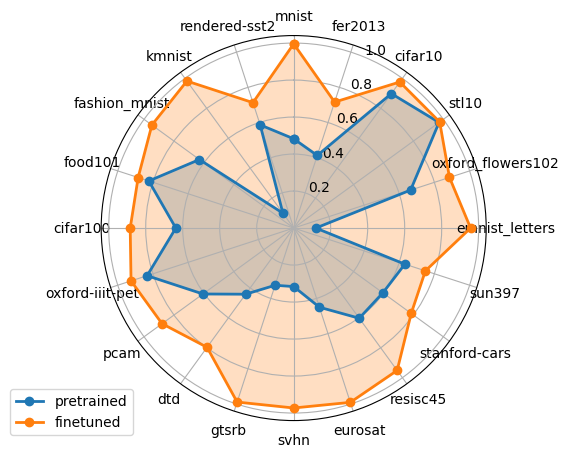

vit-b-16 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.5173,0.463918,0.9077,0.9825,0.713124,0.124375,0.655365,0.646810,0.663810,...,0.519899,0.434521,0.450000,0.540222,0.884437,0.6633,0.870139,0.6730,0.1121,0.605711
1,finetuned,0.9970,0.727640,0.9828,0.9815,0.948772,0.952837,0.789219,0.858973,0.965556,...,0.976068,0.989865,0.823404,0.905548,0.944944,0.8878,0.918653,0.9453,0.9810,0.757276


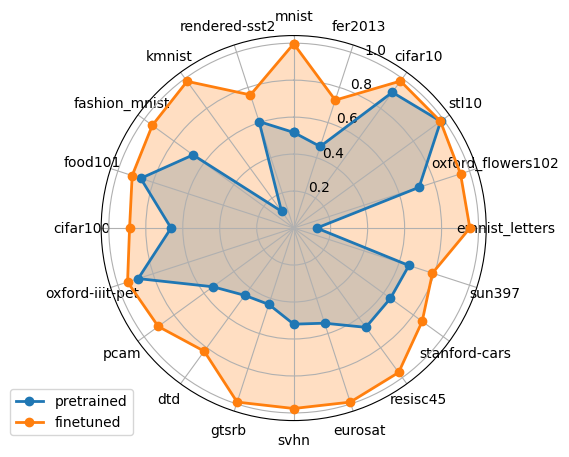

vit-l-14 results:


,model_name,mnist,fer2013,cifar10,stl10,oxford_flowers102,emnist_letters,sun397,stanford-cars,resisc45,...,svhn,gtsrb,dtd,pcam,oxford-iiit-pet,cifar100,food101,fashion_mnist,kmnist,rendered-sst2
0,pretrained,0.7631,0.499582,0.9559,0.993625,0.792487,0.123413,0.682217,0.778634,0.713333,...,0.584319,0.505226,0.555319,0.512054,0.932134,0.7505,0.911802,0.6696,0.0971,0.689182
1,finetuned,0.9976,0.759264,0.9913,0.992250,0.976744,0.954279,0.827607,0.927745,0.973810,...,0.979218,0.992399,0.854787,0.911316,0.957482,0.9300,0.947723,0.9528,0.9830,0.804503


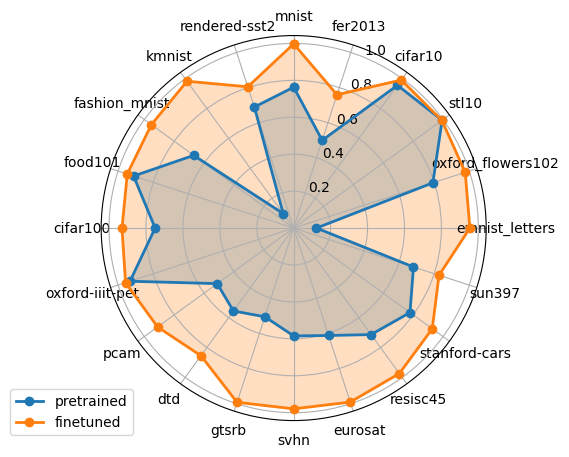

In [52]:
for base_model in ['vit-b-32', 'vit-b-16', 'vit-l-14']:
    print(f'{base_model} results:')
    df = pd.read_csv(f'results/{base_model}.csv')
    display(df)
    # plot radar chart
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='polar')
    plot_radar_chart(df, ax)
    plt.show()
